# Chapter 1 - Life and Death on the Sugarscape
We start with a simplest version of the artificial world. A single population of agents gathers a renewable source from its environment.
 

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

from matplotlib import rc
rc('animation', html='html5')

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d
from matplotlib.colors import LinearSegmentedColormap

## In The Beginning... There Was Sugar
A 2-dimension lattice or grid will represent a simple spatial distribution of "sugar", a resource that agents must eat to survive.

    - At every point(x,y) there is a sugar level and a sugar capacity.
    - Inhabitants (agents) collects and consumes sugar.
    - Only one agent per point in the lattice is allowed.
    - Agents can move north, south, east and west but not in diagonal.
    - Agents have a level of vision and metabolism.

Before starting out lattice we are going to set of local environmental rules. One of the rules is about the growing of sugar after having haversted by the agents, various rules are possible:
    - Sugar grows up instantly to its capacity.
    - Sugar grows up at a rate of unit per time step.
    - Sugar grows up at different rates in different regions of the sugarscape.
    - Sugar grows up based on the sugar level of its neighboring sites.

The function creates the sugarscape lattice.

In [2]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    left = np.repeat(np.arange(m), n)
    right = np.tile(np.arange(n), m)
    return np.transpose([left, right])

In [3]:
make_locs(4,2)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3]])

make_visible_locs takes the range of an agents vision and returns an array where each row is the coordinate of a visible cell.

The cells are at increasing distances. The cells at each distance are shuffled.

In [4]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [5]:
make_visible_locs(2)

array([[ 0, -1],
       [ 0,  1],
       [-1,  0],
       [ 1,  0],
       [-2,  0],
       [ 2,  0],
       [ 0, -2],
       [ 0,  2]])

A graphical representation of the vision range 2 array in a lattice is displayed below:
<img src="vision_location_grid.png">

Implementation of sugascape:

In [13]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
    
        self.sugarpeaks = params.get('sugarpeaks', [[15,15],[35,35]])
        #self.posY = params.get('posY', 10)
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        """Makes the capacity array."""
        
        # compute the distance of each cell from the peaks. 
        x = np.arange(self.n)
        rows, cols = np.meshgrid(x, x, indexing='ij')
        #sugarpeaksDefault = [[15,15],[35,35]]
        
        # each cell in `rows` contains its own `i` coordinate
        # each cell in `cols` contains its `j` coordinate
        # creates the sugar peaks at this positions
        #dist1 = np.hypot(self.sugarpeaks[0][0], self.sugarpeaks[0][1])
        #dist2 = np.hypot(self.sugarpeaks[1][0], self.sugarpeaks[1][1])
        #dist3 = np.hypot(rows-45, cols-self.posY)
        #dist4 = np.hypot(rows-45, cols-45)
        distHypots = []
        dist = np.hypot(rows-self.sugarpeaks[0][0], cols-self.sugarpeaks[0][1])
        for sugarpeakPos in self.sugarpeaks:
            distHypots.append(np.hypot(rows-sugarpeakPos[0], cols-sugarpeakPos[1]))
        
        #dist2 = np.hypot(rows-self.sugarpeaks[1][0], cols-self.sugarpeaks[1][1])
        for distHypot in distHypots:
            dist = np.minimum(dist, distHypot)
        
        # each cell in `dist` contains its distance to the closer peak
        #dist = np.minimum(dist1, dist2, dist3, dist4)
        #dist = np.minimum(dist1, dist2)
        #distB = np.minimum(dist3, dist4)
        #dist = np.minimum(distA, distB)
        
        # cells in the capacity array are set according to dist from peak
        a = np.zeros((self.n, self.n), np.float)
        a[dist>16] = 1
        a[dist<16] = 2
        a[dist<11] = 3
        a[dist<6] = 4
        
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = self.params.get('num_agents', 400)
        self.agents = [Agent(locs[i], self.params) 
                       for i in range(num_agents)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def look_around(self, center, vision):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
            
            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        
        # grow back some sugar
        self.grow()
        return len(self.agents)
    
    def add_agent(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

And here's a viewer that displays the state of Sugarscape.

In [14]:
class SugarscapeViewer(Cell2DViewer):
    """Generates visualization and animation of Sugarscape."""
    
    cmap = plt.get_cmap('YlOrRd')
    
    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)
    
    def draw(self, grid=False):
        """Draws the array and any other elements.
        
        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

Here's my implementation of the agents.



In [15]:
class Agent:
    
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # extract the parameters
        max_vision = params.get('max_vision', 6)
        max_metabolism = params.get('max_metabolism', 4)
        min_lifespan = params.get('min_lifespan', 10000)
        max_lifespan = params.get('max_lifespan', 10000)
        min_sugar = params.get('min_sugar', 5)
        max_sugar = params.get('max_sugar', 25)
        
        # choose attributes
        self.vision = np.random.randint(1, max_vision+1)
        self.metabolism = np.random.uniform(1, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_around(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

#### We start the replication of the sugarscape with different environments, having different number of sugar peaks and positions in each one.

In order to implent this in the _Sugarscape_ class we create an array argument with the positions of every sugar peak.

We create and array with the positions of each sugar peak.

In [26]:
sugarpeaksA = [ [25,25] ]  # One main central sugar peak
sugarpeaksB = [ [15,15], [35,35] ] # Standard sugar peaks as book replicates it
sugarpeaksC = [ [10,13], [24,36], [37,12] ] # 3 sugar peaks
sugarpeaksD = [ [10,10], [40,10], [10,40], [40,40] ] # 4 sugar peaks
sugarpeaksE = [ [5,5], [45,5], [25,25], [5,45], [45,45] ] # 5 sugar peaks


The replication will run with a grid n=50 and 400 agents.

##### One main central sugar peak

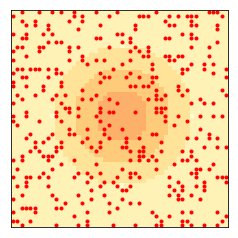

In [52]:
envA = Sugarscape(50, num_agents=400, sugarpeaks=sugarpeaksA)
viewerA = SugarscapeViewer(envA)
viewerA.draw()

##### 2 sugar peaks

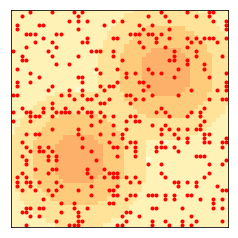

In [19]:
envB = Sugarscape(50, num_agents=400, sugarpeaks=sugarpeaksB)
viewerB = SugarscapeViewer(envB)
viewerB.draw()

##### 3 sugar peaks

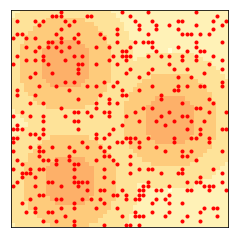

In [27]:
envC = Sugarscape(50, num_agents=400, sugarpeaks=sugarpeaksC)
viewerC = SugarscapeViewer(envC)
viewerC.draw()

##### 4 sugar peaks

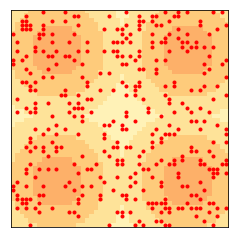

In [24]:
envD = Sugarscape(50, num_agents=400, sugarpeaks=sugarpeaksD)
viewerD = SugarscapeViewer(envD)
viewerD.draw()

##### 5 sugar peaks

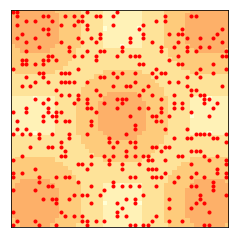

In [25]:
envE = Sugarscape(50, num_agents=400, sugarpeaks=sugarpeaksE)
viewerE = SugarscapeViewer(envE)
viewerE.draw()

For all environments (A-E) the distribution of vision is uniform from 1 to 6. 

{'xscale': 'linear', 'yscale': 'linear'}

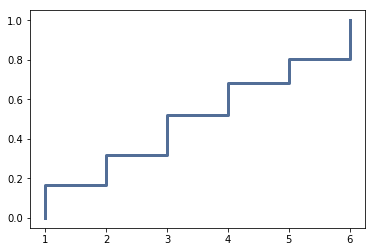

In [41]:
cdf = Cdf(agent.vision for agent in envA.agents)
thinkplot.Cdf(cdf)

For all environments (A-E) the distribution of metabolism is uniform from 1 to 4.

{'xscale': 'linear', 'yscale': 'linear'}

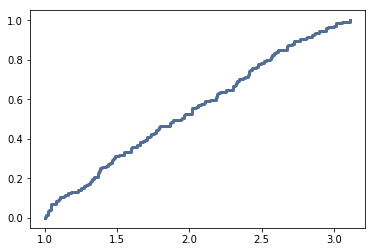

In [42]:
cdf = Cdf(agent.metabolism for agent in envA.agents)
thinkplot.Cdf(cdf)

As well the distribution of initial endowment of sugar is uniform from 5 to 25 in all environments (A-E).

{'xscale': 'linear', 'yscale': 'linear'}

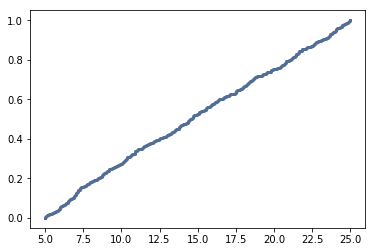

In [53]:
cdf = Cdf(agent.sugar for agent in envA.agents)
thinkplot.Cdf(cdf)

In [79]:
def custom_plot1(ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    x1 = np.linspace(0.0, 5.0)
    y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
    ax.plot(x1, y1, 'ko-')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Damped oscillation')

def custom_plot2(ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    x2 = np.linspace(0.0, 2.0)
    y2 = np.cos(2 * np.pi * x2)
    ax.plot(x2, y2, 'r.-')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Undamped')


'\nax4 = fig.add_subplot(2,2,1)\nenvD.step()\nviewerD  =  SugarscapeViewer(envD)\nviewerD.draw()\n\nax5 = fig.add_subplot(2,2,2)\nenvE.step()\nviewerE  =  SugarscapeViewer(envE)\nviewerE.draw()'

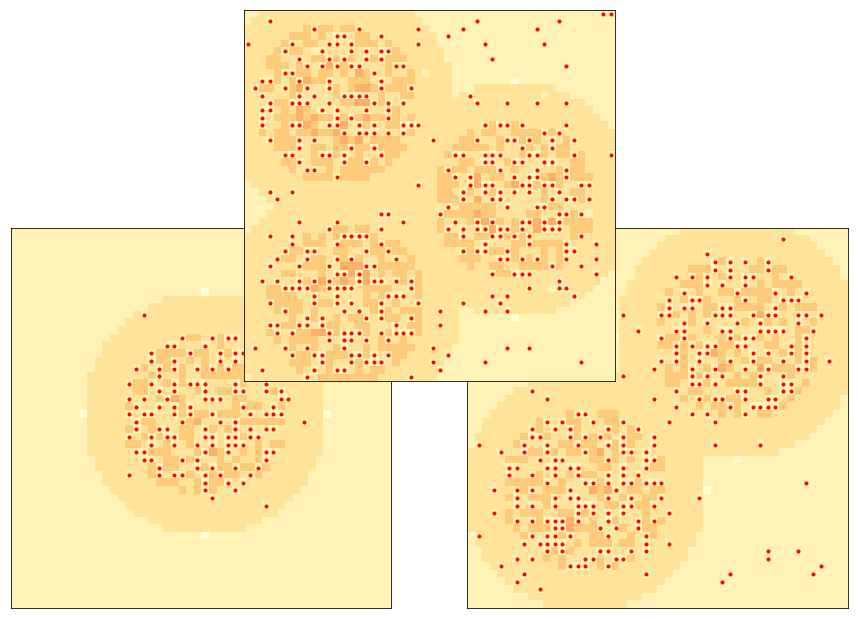

In [94]:
# 1. Plot in same line, this would work
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(1,2,1)
envA.step()
viewerA  =  SugarscapeViewer(envA)
viewerA.draw()

ax2 = fig.add_subplot(1,2,2)
envB.step()
viewerB  =  SugarscapeViewer(envB)
viewerB.draw()

ax3 = fig.add_subplot(2,1,1)
envC.step()
viewerC  =  SugarscapeViewer(envC)
viewerC.draw()
"""
ax4 = fig.add_subplot(2,2,1)
envD.step()
viewerD  =  SugarscapeViewer(envD)
viewerD.draw()

ax5 = fig.add_subplot(2,2,2)
envE.step()
viewerE  =  SugarscapeViewer(envE)
viewerE.draw()"""


Here's what the animation looks like.

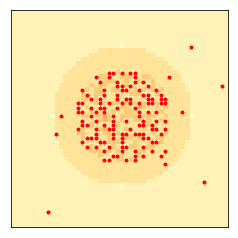

In [61]:
animA  =  viewerA.animate(frames=500)

In [62]:
animA

The number of agents levels off at the "carrying capacity":

In [65]:
len(envA.agents)

130

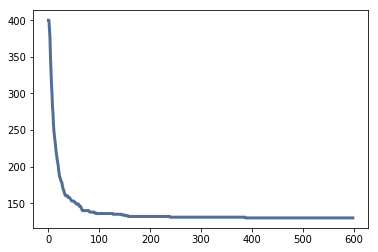

In [66]:
thinkplot.plot(envA.agent_count_seq)

This figure shows the state of the system after 2 and 10 steps.

In [ ]:
RandomSeed (17)

env = Sugarscape(50, num_agents=400)
viewer = SugarscapeViewer(env)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(2):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(98):
    viewer.step()
viewer.draw()

plt.savefig('chap09-3.pdf')

### Experiment with different numbers of agents. Try increasing or decreasing their vision or metabolism, and see what effect is has on carrying capacity.

## Sugarscape with finite lifespans
Now we start with 250 agents, with lifetimes from 60 to 100, and replacement.

In [ ]:
env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

viewer = SugarscapeViewer(env)
anim = viewer.animate(frames=100)

Here's what the animation looks like:

In [ ]:
anim

After 100 time steps, the distribution of wealth is skewed to the right. Most agents have very little sugar, but a few have a lot.

In [ ]:
cdf = Cdf(agent.sugar for agent in env.agents)
thinkplot.Cdf(cdf)
thinkplot.config(xlabel='Wealth', ylabel='CDF')

In [ ]:
cdf.Percentiles([25, 50, 75, 90])

Starting with the same parameters, I'll run the model 500 steps, recording the distribution of wealth after each 100 steps:

In [ ]:
RandomSeed(17)

env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

cdfs = []
for i in range(5):
    [env.step() for i in range(100)]
    cdf = Cdf(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

After about 200 steps, the distribution is stationary (doesn't change over time).

On a log scale, it is approximately normal, possibly with a truncated right tail.

In [ ]:

thinkplot.preplot(cols=2)

thinkplot.Cdfs(cdfs[:-1], color='gray', alpha=0.3)
thinkplot.Cdf(cdfs[-1])
thinkplot.config(xlabel='Weath', ylabel='CDF')

thinkplot.subplot(2)
thinkplot.Cdfs(cdfs[:-1], color='gray', alpha=0.3)
thinkplot.Cdf(cdfs[-1])
thinkplot.config(xlabel='Weath', ylabel='CDF', xscale='log')

plt.savefig('chap09-4.pdf')

## Experiment with different starting conditions and agents with different vision, metabolism, and lifespan. What effect do these changes have on the distribution of wealth?

# Migration in waves
If we start with all agents in the lower left, they propagate up and to the right in waves.

In [ ]:
RandomSeed (17)

env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
    
viewer = SugarscapeViewer(env)
anim = viewer.animate(frames=20, interval=500)

In [ ]:
anim

In [ ]:
env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
viewer = SugarscapeViewer(env)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
for i in range(6):
    viewer.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(6):
    viewer.step()
viewer.draw()

plt.savefig('chap09-5.pdf')

This example is interesting because the waves move diagonally, unlike the agents, who can only move up or to the right. They are similar in some ways to gliders and other Game of Life spaceships.

## Exercise: Again, experiment with different starting conditions and see what effect they have on the wave behavior.